In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Regression Lineal Multiple para predecir cosumo de combustible de un carror en base a unos features ###

# Carga de datos
df = pd.read_csv('./data/Fuel_Consumption_2000-2022.csv')
df.head()

,YEAR,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198


In [3]:
# Extracción de las columnas interesantes
features = df[['YEAR','ENGINE SIZE','CYLINDERS','EMISSIONS','FUEL CONSUMPTION']]
features.head()

,YEAR,ENGINE SIZE,CYLINDERS,EMISSIONS,FUEL CONSUMPTION
0,2000,1.6,4,186,9.2
1,2000,1.6,4,175,8.5
2,2000,3.2,6,230,12.2
3,2000,3.5,6,264,13.4
4,2000,1.8,4,198,10.0


In [4]:
### Mini EDA ###
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22556 entries, 0 to 22555
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              22556 non-null  int64  
 1   ENGINE SIZE       22556 non-null  float64
 2   CYLINDERS         22556 non-null  int64  
 3   EMISSIONS         22556 non-null  int64  
 4   FUEL CONSUMPTION  22556 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 881.2 KB


In [5]:
features.isnull().sum()

YEAR                0
ENGINE SIZE         0
CYLINDERS           0
EMISSIONS           0
FUEL CONSUMPTION    0
dtype: int64

In [6]:
features.describe()

,YEAR,ENGINE SIZE,CYLINDERS,EMISSIONS,FUEL CONSUMPTION
count,22556.000000,22556.000000,22556.000000,22556.000000,22556.000000
mean,2011.554442,3.356646,5.854141,250.068452,12.763513
std,6.298269,1.335425,1.819597,59.355276,3.500999
min,2000.000000,0.800000,2.000000,83.000000,3.500000
25%,2006.000000,2.300000,4.000000,209.000000,10.400000
50%,2012.000000,3.000000,6.000000,243.000000,12.300000
75%,2017.000000,4.200000,8.000000,288.000000,14.725000
max,2022.000000,8.400000,16.000000,608.000000,30.600000


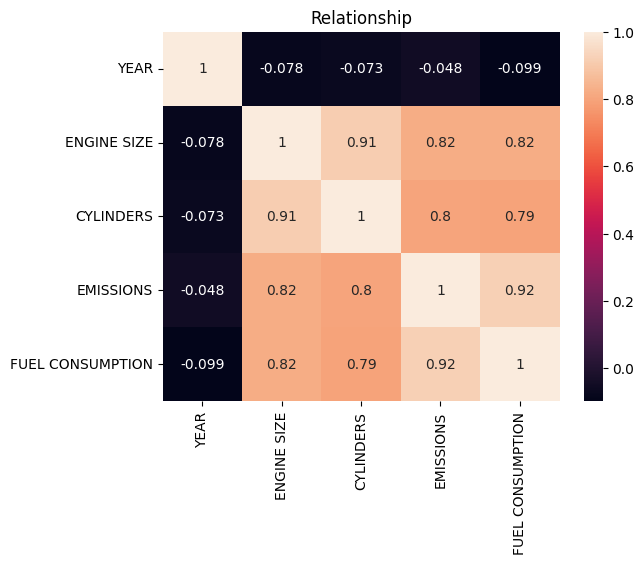

In [7]:
### Correlacion de las varibles con el cosumo de gasolina ###

# Calcula la matriz de correlación de todas las variables en el DataFrame 'features'.
# 'features.corr()' mide la relación lineal entre cada par de variables.
# El parámetro 'annot=True' muestra los valores de correlación en el mapa de calor.
sns.heatmap(features.corr(), annot=True)
plt.title('Relationship')
plt.show()

In [8]:
## Eliminar columnas con poca correlacion ##
features = features.drop(columns=['YEAR'])

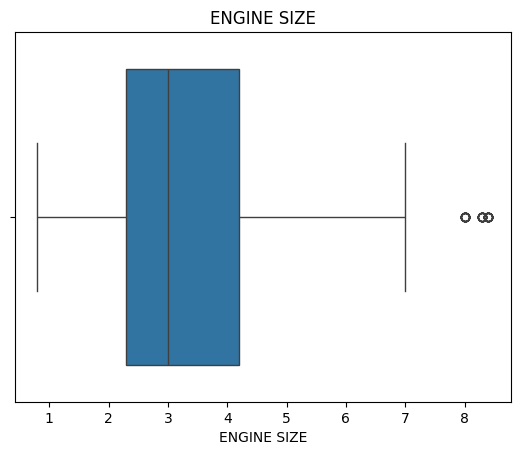

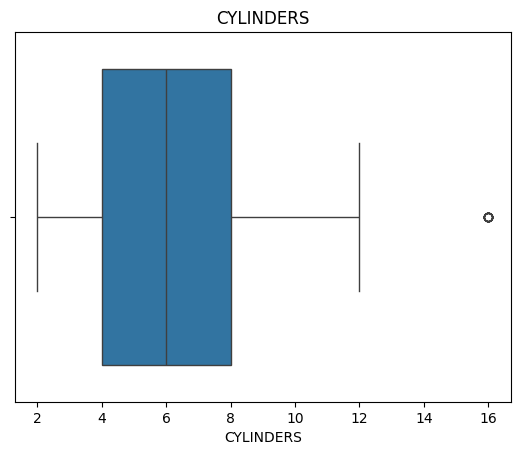

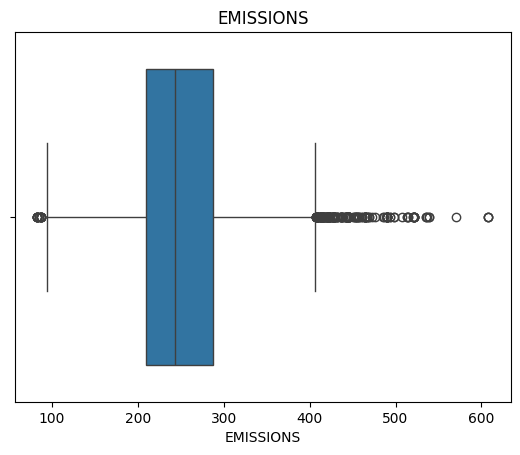

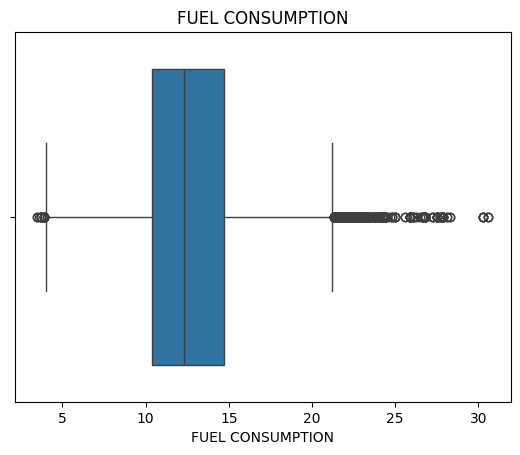

In [9]:
### Detectar y eliminar outliers ###

# Se itera sobre cada columna del DataFrame 'features'.
# 'col' representará el nombre de la columna en cada iteración.
for col in features.columns:
    # Crea un diagrama de caja (boxplot) para la columna actual.
    sns.boxplot(features, x=col)
    # Asigna el nombre de la columna como título de la gráfica.
    plt.title(col)
    # El bucle genera una gráfica por cada columna del DataFrame.
    plt.show()

In [10]:
# Quedarse con los que tengan emisiones menores o iguales a 400
features = features[features['EMISSIONS']<=400]

In [11]:
import numpy as np

def calculate_model(W, b, X):
    """Calcula el modelo de regresión lineal.

    Esta función realiza la operación de regresión lineal $y = X \\cdot W + b$.
    Maneja el ajuste de las dimensiones de los arrays de entrada para asegurar
    que la multiplicación matricial sea válida.

    Args:
        W (np.ndarray): Array de pesos (pesos) del modelo.
        b (np.ndarray or float): Bias del modelo.
        X (np.ndarray): Matriz de características (features) de entrada.

    Returns:
        np.ndarray: Las predicciones del modelo.

    Raises:
        ValueError: Si las dimensiones de `W` y `X` son incompatibles para
                    la multiplicación matricial.
    """
    # Forzar shapes correctas
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if W.ndim == 1:
        W = W.reshape(-1, 1)
    
    if W.shape[0] != X.shape[1]:
        raise ValueError(f"Dimensiones incompatibles: X {X.shape}, W {W.shape}")
    
    return X @ W + b


def mse(y_true, y_pred):
    """Calcula el Error Cuadrático Medio (MSE).

    El MSE mide la diferencia cuadrática promedio entre los valores verdaderos
    y los valores predichos.

    Args:
        y_true (np.ndarray): Valores verdaderos.
        y_pred (np.ndarray): Valores predichos por el modelo.

    Returns:
        float: El valor del MSE.
    """
    return np.mean((y_true - y_pred)**2)


def gradient_decent(W, b, lr, X, y):
    """Realiza un paso de descenso de gradiente.

    Actualiza los pesos (W) y el bias (b) del modelo utilizando el algoritmo
    de descenso de gradiente para minimizar la función de coste.

    Args:
        W (np.ndarray): Pesos actuales del modelo.
        b (np.ndarray or float): Bias actual del modelo.
        lr (float): Tasa de aprendizaje (learning rate).
        X (np.ndarray): Matriz de características de entrada.
        y (np.ndarray): Valores verdaderos.

    Returns:
        tuple: Una tupla que contiene los pesos `W` y el bias `b` actualizados.
    """
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    if W.ndim == 1:
        W = W.reshape(-1, 1)

    n = X.shape[0]
    y_pred = calculate_model(W, b, X)
    error = y - y_pred

    dW = -(2/n) * (X.T @ error)
    db = -(2/n) * error.sum()

    W -= lr * dW
    b -= lr * db
    return W, b

In [12]:
### Definicion de variables y parametros ###

# Define las características de entrada (X) del modelo.
# Se convierte a un array de NumPy.
X = features[['ENGINE SIZE','CYLINDERS','EMISSIONS']].values

# Define la variable objetivo (y).
y = features['FUEL CONSUMPTION'].values

# Ajusta la forma de 'y' para que sea un vector columna.
y = y.reshape(-1,1)

# Inicializa los pesos (W) del modelo con ceros.
W = np.zeros((X.shape[1]))

# Inicializa el bias (b) del modelo en cero.
b = 0

# Tasa de aprendizaje (learning rate) para el descenso de gradiente.
lr = 0.01

# Lista para almacenar el historial de errores durante el entrenamiento.
error_history = []

# Número de épocas, o iteraciones de entrenamiento.
epochs = 1000

In [13]:
# Muestra las características de entrada (X), que es el conjunto de datos
# con los que se entrenará el modelo.
print('X:', X)
print()
# Muestra los pesos (W) inicializados del modelo, que son los valores
# que el modelo aprenderá a ajustar durante el entrenamiento.
print('W:', W)
print()
# Muestra la variable objetivo (y), que son los valores que el modelo
# intentará predecir.
print('y:', y)

X: [[  1.6   4.  186. ]
 [  1.6   4.  175. ]
 [  3.2   6.  230. ]
 ...
 [  2.    4.  232. ]
 [  2.    4.  236. ]
 [  2.    4.  252. ]]

W: [0. 0. 0.]

y: [[ 9.2]
 [ 8.5]
 [12.2]
 ...
 [11. ]
 [11.5]
 [12.4]]


In [14]:
## Normalizacion de los datos (X) ##
X_norm = (X - X.mean(axis=0))/(X.std(axis=0))
print('X_norm:\n',X_norm)

X_norm:
 [[-1.32010513 -1.02776627 -1.10497969]
 [-1.32010513 -1.02776627 -1.3009647 ]
 [-0.09756934  0.10822879 -0.32103967]
 ...
 [-1.01447118 -1.02776627 -0.28540603]
 [-1.01447118 -1.02776627 -0.21413876]
 [-1.01447118 -1.02776627  0.07093034]]


In [15]:
print(f"Shape of X_norm: {X_norm.shape}")
print(f"Shape of y: {y.shape}")

Shape of X_norm: (22315, 3)
Shape of y: (22315, 1)


Epoch: 100 
MSE: 4.8312
W:  [[0.86787466]
 [0.72372368]
 [1.54424364]]
b:  10.975901716718548
Epoch: 200 
MSE: 1.8914
W:  [[0.75810911]
 [0.51918454]
 [1.88555557]]
b:  12.431520927934217
Epoch: 300 
MSE: 1.7742
W:  [[0.69100029]
 [0.38402619]
 [2.09694574]]
b:  12.624564501277511
Epoch: 400 
MSE: 1.7461
W:  [[0.65263545]
 [0.29568036]
 [2.22930519]]
b:  12.650165854242635
Epoch: 500 
MSE: 1.7352
W:  [[0.63175631]
 [0.23727561]
 [2.3120943 ]]
b:  12.653561094303171
Epoch: 600 
MSE: 1.7309
W:  [[0.62136905]
 [0.1981233 ]
 [2.36379927]]
b:  12.654011369532162
Epoch: 700 
MSE: 1.7291
W:  [[0.61715555]
 [0.17144125]
 [2.39602417]]
b:  12.654071084833058
Epoch: 800 
MSE: 1.7283
W:  [[0.616467  ]
 [0.15291161]
 [2.41605123]]
b:  12.654079004249748
Epoch: 900 
MSE: 1.7280
W:  [[0.61769351]
 [0.13977331]
 [2.42844898]]
b:  12.654080054519266
Epoch: 1000 
MSE: 1.7278
W:  [[0.61986948]
 [0.13025064]
 [2.43608215]]
b:  12.654080193805548


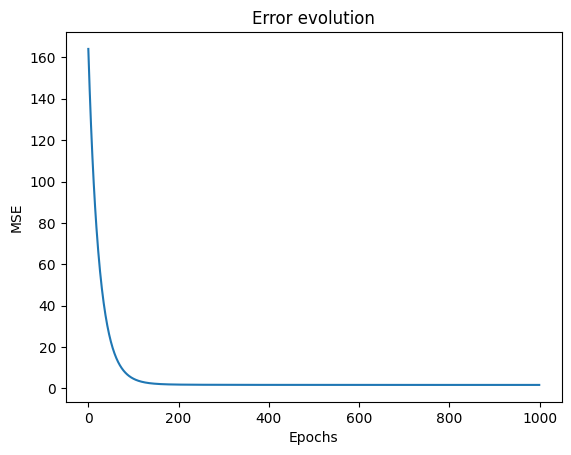

In [16]:
### Training ###
# Inicia un bucle que se ejecutará el número de veces definido por 'epochs'.
# Cada iteración del bucle representa una época de entrenamiento.
for i in range(epochs):
    # Calcula el descenso de gradiente para actualizar los pesos (W) y el bias (b).
    # Esta función ajusta los parámetros del modelo para reducir el error.
    W, b = gradient_decent(W, b, lr, X_norm, y)
    
    # Usa el modelo con los nuevos pesos y bias para hacer una predicción.
    y_pred = calculate_model(W, b, X_norm)
    
    # Calcula el Error Cuadrático Medio (MSE) para medir el rendimiento del modelo.
    # El MSE cuantifica la diferencia entre los valores reales (y) y los predichos (y_pred).
    error = mse(y, y_pred)
    
    # Almacena el valor del error en cada época para poder graficarlo después.
    error_history.append(error)
    
    # Imprime el progreso cada 100 épocas. Esto ayuda a monitorear el entrenamiento.
    if (i + 1) % 100 == 0:
        # Muestra el número de la época actual y el valor del MSE.
        print(f'Epoch: {i + 1} \nMSE: {error:.4f}')
        # Muestra los valores actuales de los pesos (W) para ver cómo cambian.
        print('W: ', W)
        # Muestra el valor actual del bias (b).
        print('b: ', b)

### Graficar la curva de aprendizaje ###
# Crea una gráfica para visualizar cómo evoluciona el error a lo largo del tiempo.
# El eje X son las épocas, y el eje Y es el error (MSE).
plt.plot(range(epochs), error_history)
plt.title('Error evolution')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [17]:
error_history[-1] # Ultimo valor del mse

np.float64(1.7278337972346434)

In [18]:
### Predicciones ###
# Target = FUEL CONSUMPTION
ENGINE_SIZE, CYLINDERS, EMISSIONS = 4,6,140
# Nuevo dato (m características)
new_data = np.array([ENGINE_SIZE, CYLINDERS, EMISSIONS])  # ejemplo con 3 features

# Normalizar igual que antes
new_norm = (new_data - X.mean(axis=0)) / X.std(axis=0)

# Darle forma (1 fila, m columnas)
new_norm = new_norm.reshape(1, -1)

# Predicción
prediction = calculate_model(W, b, new_norm)
print(f'Predicción (FUEL CONSUMPTION): {prediction[0][0]:.2f}L')

Predicción (FUEL CONSUMPTION): 8.30L


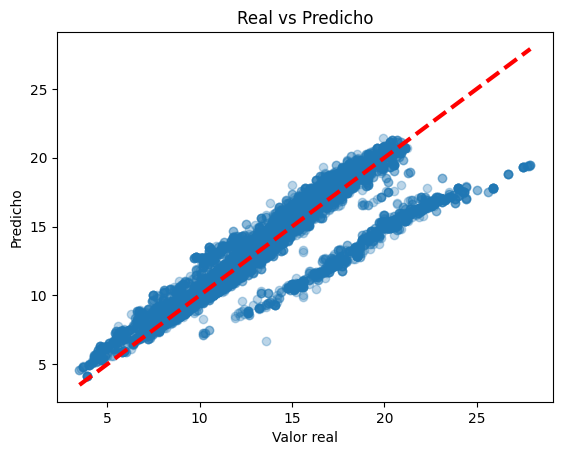

In [19]:
## Grafico de dispersion real vs predicho ##
y_pred_train = calculate_model(W, b, X_norm)
plt.scatter(y, y_pred_train,alpha=.3)
plt.xlabel("Valor real")
plt.ylabel("Predicho")
plt.title("Real vs Predicho")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--",linewidth=3)  # línea ideal
plt.show()